In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

In [5]:
nlp=spacy.load("en_core_web_sm")

In [6]:
#this func removes STOPWORDS and PUNCTUATION from the String

def text_process(message):
    doc=nlp(message)
    final=[token.lemma_ for token in doc if token.is_stop== False and token.text.isalpha()== True ]
    return " ".join(final)

In [7]:
# processed=train["comment_text"].apply(text_process)

In [8]:
# train["filtered"]=processed

In [9]:
# df["filtered"]=df["filtered"].apply(lambda x: np.str_(x))

In [10]:
df=pd.read_csv("filtered_text.csv")

In [11]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_train = train[list_classes].values
x_train = train["comment_text"]
x_test = test["comment_text"]

In [23]:
# y_train[888]

array([1, 0, 0, 0, 1, 0])

In [24]:
VOCAB_SIZE = 20000

MAXLEN =200
BATCH_SIZE = 32

In [13]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(list(x_train)) #sets-up internal vocabulary

list_tokenized_train = tokenizer.texts_to_sequences(x_train)  #assigns unique id to each word
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

In [14]:
print(list_tokenized_train[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [25]:
Pad_train = pad_sequences(list_tokenized_train, maxlen=MAXLEN)  #pre-padding
Pad_test = pad_sequences(list_tokenized_test, maxlen=MAXLEN)

- A simple/intuitive explanation for RNNs is that, post-padding seems to add noise to what has been learned from the sequence through time, and there aren't more timesteps for the RNN to recover from this noise. 
- With pre-padding, however, the RNN is better able to adjust to the added noise of zeros at the beginning as it learns from the sequence through time.

In [11]:
print(Pad_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0   688    75     1
   126   130   177    29   672  4511 12052  1116   

Learn about stacked LSTM: https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

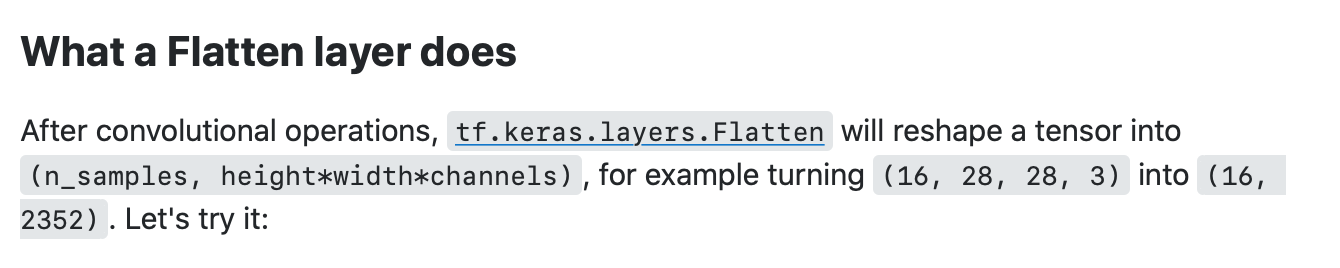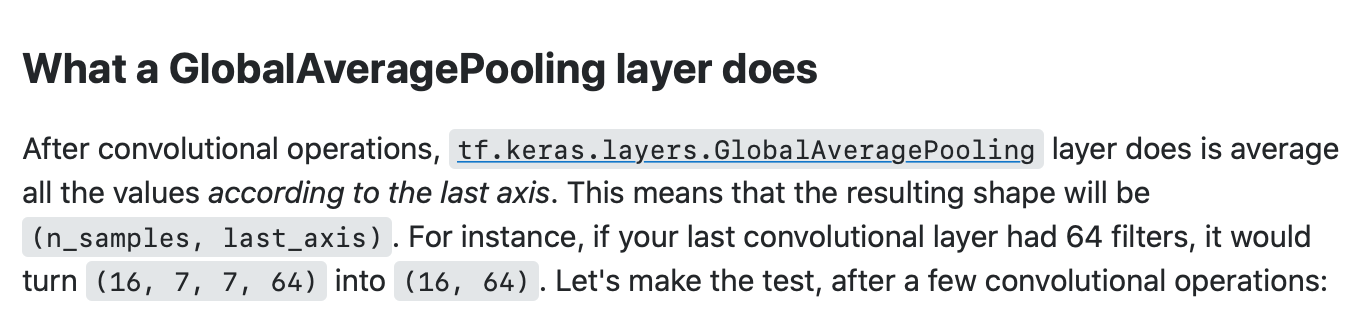

GlobalMax/AveragePooling is a methodology used for better representation of your vector. It can be 1D/2D/3D. It uses a parser window which moves across the object and pools the data by averaging it (GlobalAveragePooling) or picking max value (GlobalMaxPooling). Padding is essentially required to take the corner cases into the account.

In [12]:
input_layer = Input(shape=(MAXLEN, ))
embed_size = 128
output_layer = Embedding(VOCAB_SIZE, embed_size)(input_layer)  
output_layer = LSTM(60, return_sequences=True,name='lstm_layer')(output_layer)
#flatten() would have also worked, MaxPooling decreases the computation cost
output_layer = GlobalMaxPool1D()(output_layer)
output_layer = Dropout(0.1)(output_layer)
output_layer = Dense(50, activation="relu")(output_layer)
output_layer = Dropout(0.1)(output_layer)
output_layer = Dense(6, activation="sigmoid")(output_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class.

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [32]:
model.fit(Pad_train,y_train,batch_size=BATCH_SIZE,epochs=2,validation_split=0.2)

Epoch 1/2
3990/3990 [==============================] - 520s 130ms/step - loss: 0.1134 - accuracy: 0.8988 - val_loss: 0.0500 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 510s 128ms/step - loss: 0.0457 - accuracy: 0.9868 - val_loss: 0.0466 - val_accuracy: 0.9938


In [33]:
predictions=model.predict(Pad_test,batch_size=BATCH_SIZE,verbose=0)

batch_size: The reason is the same , why you need batch size for training, because you cannot fit all data into one single batch

Similarly, if you have millions of data points to predict, it is obviously that you will not be able to pass at one go (single batch).



In [90]:
predictions[0]

array([0.9912318 , 0.3392669 , 0.91001475, 0.08794069, 0.8369621 ,
       0.29097253], dtype=float32)

In [105]:
def predict(text):
  test_sequences=tokenizer.texts_to_sequences(text)
  data_test=pad_sequences(test_sequences,maxlen=MAXLEN)
  predictions=model.predict(data_test,verbose=0)
  return predictions

In [26]:
text=input("Enter your text:")

Enter your text:hey nigger


In [28]:
x=predict(text)

In [111]:
x[0]

array([0.13242236, 0.00177005, 0.03398108, 0.00633249, 0.03787673,
       0.01020342], dtype=float32)

In [39]:
# joblib.dump(model, 'LSTM_Model.joblib')